In [47]:
%matplotlib inline
import pathlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 500)
from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

from torch.nn import init
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

device(type='cuda', index=0)

In [46]:
from market import *
from market_ml import *

In [48]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        self.dfcats = df[cats]
        self.dfconts = df.drop(cats, axis=1)
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64)
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        self.y = y.values.astype(np.float32)
        
    def __len__(self): return len(self.y)
 
    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

In [49]:
financial_data = pd.read_csv("csv_files/company_stats_2019-08-30.csv")
financial_data = financial_data[pd.notnull(financial_data['Industry'])] # Remove rows with nan values for industry
financial_data = financial_data[pd.notnull(financial_data['Sector'])]  # Remove rows with nan values for sector
# Convert sector and industry to categoricals
financial_data['Industry'] = financial_data['Industry'].astype('category')
financial_data['Sector'] = financial_data['Sector'].astype('category')

to_remove = ['Ticker', 'Name', 'Price', 'IPO Year']
categorical = ['Sector', 'Industry']
# Convert categorical variables to integers to feed in the model
financial_data[categorical] = financial_data[categorical].apply(lambda x: x.cat.codes)
feature_cols = [x for x in financial_data.columns if x not in to_remove]
financial_data = financial_data.fillna(0)
X = financial_data[feature_cols]
Y = financial_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    
trainds = RegressionColumnarDataset(X_train, categorical, y_train)
valds = RegressionColumnarDataset(X_test, categorical, y_test)
 
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 0}
 
traindl = data.DataLoader(trainds, **params)
valdl = data.DataLoader(valds, **params)

In [50]:
def emb_init(x):
    x = x.weight.data
    sc = 2/(x.size(1)+1)
    x.uniform_(-sc,sc)
    
def inv_y(y): 
    return np.exp(y)
    
def rmse(targ, y_pred):
    #print(inv_y(y_pred), inv_y(targ))
    #return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    return np.sqrt(mean_squared_error(y_pred, targ))


class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn=True):
        super().__init__()
        for i,(c,s) in enumerate(emb_szs): assert c > 1, "cardinality must be >=2, got emb_szs[{i}]: ({c},{s})"
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: nn.init.kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        nn.init.kaiming_normal_(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = torch.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x.squeeze()

In [51]:
y_range = (0, y_train.max()*1.2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using: " + str(device))
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')




cat_sz = [(c, financial_data[c].max()+1) for c in categorical]


emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]


m = MixedInputModel(emb_szs=emb_szs,
    n_cont=len(financial_data.columns)-len(categorical) - 4, 
                    emb_drop=0.04,
                    out_sz=1, 
                    szs=[1000,500,250], 
                    drops=[0.001,0.01,0.01], 
                    y_range=y_range).to(device)

Using: cuda:0


In [52]:
def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description('Epoch {epoch}')
            
            opt.zero_grad()
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            loss.backward()
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            scheduler.step()
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

In [53]:
opt = optim.Adam(m.parameters(), 1e-2)
lr_cosine = lr_scheduler.CosineAnnealingLR(opt, 1000)
 
lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)
 
lr, tloss, vloss = fit(model=m, train_dl=traindl, val_dl=valdl, loss_fn=F.mse_loss, opt=opt, scheduler=lr_cosine, epochs=200)

Epoch 0: train_loss: 153089.5365 train_rmse: 394.4388 | val_loss: 65298.7805 val_rmse: 255.3785


Epoch 1: train_loss: 42179.1292 train_rmse: 205.4767 | val_loss: 25427.4469 val_rmse: 159.5274


Epoch 2: train_loss: 24653.8368 train_rmse: 158.4100 | val_loss: 16397.6516 val_rmse: 128.0445


Epoch 3: train_loss: 15598.9467 train_rmse: 123.8032 | val_loss: 11872.8684 val_rmse: 108.8429


Epoch 4: train_loss: 12525.4009 train_rmse: 111.7700 | val_loss: 14149.6104 val_rmse: 118.8107


Epoch 5: train_loss: 12601.1106 train_rmse: 111.4841 | val_loss: 14420.7826 val_rmse: 119.9283


Epoch 6: train_loss: 11479.0892 train_rmse: 107.0985 | val_loss: 12269.1197 val_rmse: 110.6091


Epoch 7: train_loss: 10728.1954 train_rmse: 101.2354 | val_loss: 9311.5591 val_rmse: 96.4117


Epoch 8: train_loss: 10922.9166 train_rmse: 105.2568 | val_loss: 9516.8859 val_rmse: 97.6000


Epoch 9: train_loss: 8703.7929 train_rmse: 92.3821 | val_loss: 3746.5471 val_rmse: 61.2416


Epoch 10: train_loss: 2835.3908 train_rmse: 53.5715 | val_loss: 3442.7541 val_rmse: 58.4654


Epoch 11: train_loss: 3128.2841 train_rmse: 55.1063 | val_loss: 2325.8415 val_rmse: 48.2284


Epoch 12: train_loss: 2258.0735 train_rmse: 47.3616 | val_loss: 2855.9054 val_rmse: 53.2302


Epoch 13: train_loss: 2152.5707 train_rmse: 46.4116 | val_loss: 2122.1660 val_rmse: 46.1138


Epoch 14: train_loss: 2252.0066 train_rmse: 47.8165 | val_loss: 2741.6659 val_rmse: 52.3726


Epoch 15: train_loss: 1861.3909 train_rmse: 42.9361 | val_loss: 2622.1161 val_rmse: 51.2536


Epoch 16: train_loss: 2115.9595 train_rmse: 46.5155 | val_loss: 2278.3331 val_rmse: 47.7304


Epoch 17: train_loss: 1812.8305 train_rmse: 43.1888 | val_loss: 2628.1677 val_rmse: 51.1909


Epoch 18: train_loss: 1882.4365 train_rmse: 43.8631 | val_loss: 2054.9731 val_rmse: 45.2836


Epoch 19: train_loss: 1737.2220 train_rmse: 42.3461 | val_loss: 2199.9681 val_rmse: 46.8087


Epoch 20: train_loss: 1757.7107 train_rmse: 42.4829 | val_loss: 2576.0186 val_rmse: 50.6685


Epoch 21: train_loss: 1971.0527 train_rmse: 43.9887 | val_loss: 2137.0371 val_rmse: 46.3390


Epoch 22: train_loss: 1569.2352 train_rmse: 39.1768 | val_loss: 1863.7141 val_rmse: 43.0746


Epoch 23: train_loss: 1391.8394 train_rmse: 36.7925 | val_loss: 1838.7824 val_rmse: 42.9258


Epoch 24: train_loss: 1675.4261 train_rmse: 39.2382 | val_loss: 1867.3516 val_rmse: 43.2770


Epoch 25: train_loss: 1652.8437 train_rmse: 41.1922 | val_loss: 2046.8502 val_rmse: 45.2765


Epoch 26: train_loss: 1481.6461 train_rmse: 37.7385 | val_loss: 1909.3254 val_rmse: 43.7487


Epoch 27: train_loss: 1183.9660 train_rmse: 34.7289 | val_loss: 1846.3311 val_rmse: 43.0280


Epoch 28: train_loss: 1199.8231 train_rmse: 34.9551 | val_loss: 1800.5051 val_rmse: 42.5280


Epoch 29: train_loss: 1205.9791 train_rmse: 34.4388 | val_loss: 1496.8925 val_rmse: 38.7244


Epoch 30: train_loss: 1092.4942 train_rmse: 33.2141 | val_loss: 1508.9237 val_rmse: 38.7695


Epoch 31: train_loss: 991.4682 train_rmse: 31.5656 | val_loss: 1886.9127 val_rmse: 43.2605


Epoch 32: train_loss: 897.6525 train_rmse: 30.0926 | val_loss: 1847.3792 val_rmse: 42.8941


Epoch 33: train_loss: 1178.3225 train_rmse: 34.1411 | val_loss: 1559.0621 val_rmse: 39.4580


Epoch 34: train_loss: 1061.5485 train_rmse: 32.9119 | val_loss: 1615.4930 val_rmse: 40.1939


Epoch 35: train_loss: 784.7136 train_rmse: 27.8157 | val_loss: 1399.4759 val_rmse: 37.2591


Epoch 36: train_loss: 1063.3417 train_rmse: 31.9957 | val_loss: 1501.3634 val_rmse: 38.5445


Epoch 37: train_loss: 939.5959 train_rmse: 30.9679 | val_loss: 1631.3415 val_rmse: 40.4856


Epoch 38: train_loss: 886.7330 train_rmse: 30.1981 | val_loss: 2190.9296 val_rmse: 46.7595


Epoch 39: train_loss: 1031.6855 train_rmse: 32.3083 | val_loss: 1448.1893 val_rmse: 37.9542


Epoch 40: train_loss: 986.5881 train_rmse: 30.6867 | val_loss: 1472.6512 val_rmse: 38.4500


Epoch 41: train_loss: 993.0154 train_rmse: 31.5323 | val_loss: 1499.9569 val_rmse: 38.6284


Epoch 42: train_loss: 876.5974 train_rmse: 29.5679 | val_loss: 1860.5540 val_rmse: 43.1771


Epoch 43: train_loss: 705.3103 train_rmse: 26.4268 | val_loss: 1873.0824 val_rmse: 43.4214


Epoch 44: train_loss: 582.4887 train_rmse: 24.3616 | val_loss: 1608.5177 val_rmse: 40.0102


Epoch 45: train_loss: 873.4953 train_rmse: 29.7713 | val_loss: 1632.5573 val_rmse: 40.5254


Epoch 46: train_loss: 789.7162 train_rmse: 28.3057 | val_loss: 1746.7581 val_rmse: 41.6809


Epoch 47: train_loss: 1027.4066 train_rmse: 32.2076 | val_loss: 1947.6677 val_rmse: 44.1565


Epoch 48: train_loss: 1047.0828 train_rmse: 32.0612 | val_loss: 1772.6808 val_rmse: 42.0213


Epoch 49: train_loss: 1037.7253 train_rmse: 32.1439 | val_loss: 1342.9485 val_rmse: 36.7131


Epoch 50: train_loss: 1049.6552 train_rmse: 32.5252 | val_loss: 1562.7964 val_rmse: 39.5171


Epoch 51: train_loss: 1024.5035 train_rmse: 31.3539 | val_loss: 1285.5146 val_rmse: 35.9200


Epoch 52: train_loss: 887.4835 train_rmse: 29.8321 | val_loss: 1343.9074 val_rmse: 36.7608


Epoch 53: train_loss: 809.4932 train_rmse: 28.5784 | val_loss: 1635.7216 val_rmse: 40.4863


Epoch 54: train_loss: 838.6789 train_rmse: 29.0579 | val_loss: 1646.1589 val_rmse: 40.4410


Epoch 55: train_loss: 631.3142 train_rmse: 24.9720 | val_loss: 1353.3703 val_rmse: 36.8483


Epoch 56: train_loss: 654.4753 train_rmse: 25.8863 | val_loss: 1349.9618 val_rmse: 36.7278


Epoch 57: train_loss: 562.7853 train_rmse: 23.3730 | val_loss: 1203.1228 val_rmse: 34.6387


Epoch 58: train_loss: 652.3179 train_rmse: 25.8825 | val_loss: 1465.3836 val_rmse: 38.3494


Epoch 59: train_loss: 762.0795 train_rmse: 27.7598 | val_loss: 1281.3812 val_rmse: 35.7967


Epoch 60: train_loss: 615.5574 train_rmse: 24.5148 | val_loss: 1229.1633 val_rmse: 34.9498


Epoch 61: train_loss: 587.9273 train_rmse: 24.0086 | val_loss: 1161.5846 val_rmse: 34.1226


Epoch 62: train_loss: 792.6336 train_rmse: 28.3331 | val_loss: 1093.6097 val_rmse: 33.1377


Epoch 63: train_loss: 831.3693 train_rmse: 28.7864 | val_loss: 1292.3467 val_rmse: 36.0180


Epoch 64: train_loss: 776.1610 train_rmse: 28.0261 | val_loss: 1350.4110 val_rmse: 36.7565


Epoch 65: train_loss: 533.7223 train_rmse: 22.6545 | val_loss: 1224.2781 val_rmse: 35.0529


Epoch 66: train_loss: 697.9368 train_rmse: 26.5962 | val_loss: 1064.1388 val_rmse: 32.6976


Epoch 67: train_loss: 599.4264 train_rmse: 23.8226 | val_loss: 1098.8254 val_rmse: 33.1846


Epoch 68: train_loss: 595.1696 train_rmse: 24.0830 | val_loss: 1340.1639 val_rmse: 36.5099


Epoch 69: train_loss: 740.7570 train_rmse: 27.1636 | val_loss: 1311.6940 val_rmse: 36.1967


Epoch 70: train_loss: 478.0687 train_rmse: 21.1484 | val_loss: 1242.0025 val_rmse: 35.2523


Epoch 71: train_loss: 557.5406 train_rmse: 23.8449 | val_loss: 882.1111 val_rmse: 29.5563


Epoch 72: train_loss: 704.5546 train_rmse: 26.3366 | val_loss: 1017.9694 val_rmse: 31.9670


Epoch 73: train_loss: 670.7531 train_rmse: 26.2668 | val_loss: 1301.4517 val_rmse: 36.1775


Epoch 74: train_loss: 606.3432 train_rmse: 24.6785 | val_loss: 1154.5287 val_rmse: 34.0348


Epoch 75: train_loss: 690.1970 train_rmse: 26.0844 | val_loss: 1222.3530 val_rmse: 34.9682


Epoch 76: train_loss: 532.9760 train_rmse: 23.2083 | val_loss: 1265.4373 val_rmse: 35.5928


Epoch 77: train_loss: 761.3725 train_rmse: 27.5798 | val_loss: 1246.6351 val_rmse: 35.3154


Epoch 78: train_loss: 546.0926 train_rmse: 23.4510 | val_loss: 1252.1828 val_rmse: 35.4259


Epoch 79: train_loss: 739.1819 train_rmse: 27.4883 | val_loss: 1260.8392 val_rmse: 35.5711


Epoch 80: train_loss: 654.3003 train_rmse: 25.9688 | val_loss: 1248.3999 val_rmse: 35.4344


Epoch 81: train_loss: 584.6994 train_rmse: 23.9143 | val_loss: 968.7315 val_rmse: 31.1445


Epoch 82: train_loss: 561.5215 train_rmse: 23.8606 | val_loss: 1245.5720 val_rmse: 35.3652


Epoch 83: train_loss: 615.8322 train_rmse: 24.7548 | val_loss: 1385.6599 val_rmse: 37.0815


Epoch 84: train_loss: 530.7604 train_rmse: 23.2952 | val_loss: 1268.7753 val_rmse: 35.6358


Epoch 85: train_loss: 523.9934 train_rmse: 22.7182 | val_loss: 1259.2026 val_rmse: 35.5318


Epoch 86: train_loss: 879.9387 train_rmse: 26.9614 | val_loss: 1117.8678 val_rmse: 33.4717


Epoch 87: train_loss: 541.0380 train_rmse: 23.5727 | val_loss: 1423.0369 val_rmse: 37.7402


Epoch 88: train_loss: 706.1777 train_rmse: 25.7676 | val_loss: 1394.9462 val_rmse: 37.3529


Epoch 89: train_loss: 412.9276 train_rmse: 19.9841 | val_loss: 1288.1633 val_rmse: 35.9842


Epoch 90: train_loss: 864.8923 train_rmse: 26.9028 | val_loss: 1413.4529 val_rmse: 37.4711


Epoch 91: train_loss: 816.4945 train_rmse: 28.6210 | val_loss: 1054.9899 val_rmse: 32.5082


Epoch 92: train_loss: 572.2301 train_rmse: 23.8263 | val_loss: 1331.5832 val_rmse: 36.4365


Epoch 93: train_loss: 746.0365 train_rmse: 26.8691 | val_loss: 1147.3940 val_rmse: 33.8938


Epoch 94: train_loss: 642.7518 train_rmse: 25.6593 | val_loss: 1020.7045 val_rmse: 31.8634


Epoch 95: train_loss: 714.2283 train_rmse: 26.5552 | val_loss: 1104.0032 val_rmse: 33.2518


Epoch 96: train_loss: 619.6517 train_rmse: 24.1864 | val_loss: 1208.5951 val_rmse: 34.8198


Epoch 97: train_loss: 456.4470 train_rmse: 21.1240 | val_loss: 1294.2115 val_rmse: 35.8535


Epoch 98: train_loss: 560.2953 train_rmse: 22.5352 | val_loss: 1308.3587 val_rmse: 36.2096


Epoch 99: train_loss: 520.0479 train_rmse: 22.5609 | val_loss: 1384.0800 val_rmse: 37.0619


Epoch 100: train_loss: 605.5029 train_rmse: 24.2789 | val_loss: 1045.5834 val_rmse: 32.3733


Epoch 101: train_loss: 446.7185 train_rmse: 21.2384 | val_loss: 780.9048 val_rmse: 27.9986


Epoch 102: train_loss: 563.0607 train_rmse: 22.8901 | val_loss: 1330.6111 val_rmse: 36.5412


Epoch 103: train_loss: 512.6787 train_rmse: 22.6791 | val_loss: 872.2286 val_rmse: 29.5584


Epoch 104: train_loss: 657.0367 train_rmse: 25.8764 | val_loss: 1166.0818 val_rmse: 34.0850


Epoch 105: train_loss: 650.2398 train_rmse: 25.3223 | val_loss: 1268.7282 val_rmse: 35.5440


Epoch 106: train_loss: 659.9074 train_rmse: 25.6516 | val_loss: 1212.9522 val_rmse: 34.8684


Epoch 107: train_loss: 791.3949 train_rmse: 28.0894 | val_loss: 1317.4617 val_rmse: 36.2169


Epoch 108: train_loss: 579.7160 train_rmse: 24.2580 | val_loss: 1149.2926 val_rmse: 33.9996


Epoch 109: train_loss: 568.4872 train_rmse: 23.9476 | val_loss: 1205.5622 val_rmse: 34.7960


Epoch 110: train_loss: 605.1416 train_rmse: 24.9177 | val_loss: 2034.4361 val_rmse: 45.1759


Epoch 111: train_loss: 788.0242 train_rmse: 28.4312 | val_loss: 1974.2419 val_rmse: 44.5147


Epoch 112: train_loss: 482.1892 train_rmse: 21.8885 | val_loss: 1689.9835 val_rmse: 41.1991


Epoch 113: train_loss: 533.1920 train_rmse: 23.2941 | val_loss: 901.6378 val_rmse: 30.0730


Epoch 114: train_loss: 432.0762 train_rmse: 20.3578 | val_loss: 1380.8236 val_rmse: 37.1615


Epoch 115: train_loss: 556.6029 train_rmse: 23.7701 | val_loss: 1463.8607 val_rmse: 38.1226


Epoch 116: train_loss: 883.7273 train_rmse: 29.2124 | val_loss: 1465.3562 val_rmse: 38.2988


Epoch 117: train_loss: 759.5857 train_rmse: 26.8771 | val_loss: 1262.7932 val_rmse: 35.5969


Epoch 118: train_loss: 676.0956 train_rmse: 26.3626 | val_loss: 1296.2621 val_rmse: 35.9029


Epoch 119: train_loss: 735.3628 train_rmse: 27.2541 | val_loss: 1504.6701 val_rmse: 38.8912


Epoch 120: train_loss: 590.8626 train_rmse: 24.2911 | val_loss: 1322.6393 val_rmse: 36.3726


Epoch 121: train_loss: 854.4170 train_rmse: 29.0781 | val_loss: 1069.7841 val_rmse: 32.6779


Epoch 122: train_loss: 468.9584 train_rmse: 21.5329 | val_loss: 1354.1691 val_rmse: 36.8294


Epoch 123: train_loss: 560.8717 train_rmse: 23.8307 | val_loss: 1433.5256 val_rmse: 37.8734


Epoch 124: train_loss: 453.3873 train_rmse: 21.4700 | val_loss: 1142.3488 val_rmse: 33.8449


Epoch 125: train_loss: 820.2589 train_rmse: 27.8651 | val_loss: 2055.9644 val_rmse: 45.4806


Epoch 126: train_loss: 865.7773 train_rmse: 29.8184 | val_loss: 1386.1980 val_rmse: 37.2941


Epoch 127: train_loss: 672.2188 train_rmse: 25.7256 | val_loss: 1551.2437 val_rmse: 39.4620


Epoch 128: train_loss: 593.8234 train_rmse: 24.5886 | val_loss: 1347.0482 val_rmse: 36.6687


Epoch 129: train_loss: 497.9123 train_rmse: 22.5110 | val_loss: 1522.9851 val_rmse: 38.8732


Epoch 130: train_loss: 537.1701 train_rmse: 23.3579 | val_loss: 1093.8118 val_rmse: 33.1224


Epoch 131: train_loss: 616.4195 train_rmse: 24.2661 | val_loss: 1512.3881 val_rmse: 38.9365


Epoch 132: train_loss: 580.3335 train_rmse: 24.1110 | val_loss: 1250.9859 val_rmse: 35.4237


Epoch 133: train_loss: 606.9865 train_rmse: 23.6495 | val_loss: 1545.8517 val_rmse: 39.2578


Epoch 134: train_loss: 664.4547 train_rmse: 25.8314 | val_loss: 1266.8121 val_rmse: 35.6540


Epoch 135: train_loss: 533.0739 train_rmse: 23.1192 | val_loss: 1409.3565 val_rmse: 37.5409


Epoch 136: train_loss: 712.7767 train_rmse: 26.6102 | val_loss: 1149.7725 val_rmse: 33.9706


Epoch 137: train_loss: 550.3061 train_rmse: 23.7588 | val_loss: 1297.6470 val_rmse: 36.0781


Epoch 138: train_loss: 521.3238 train_rmse: 22.8963 | val_loss: 1394.2336 val_rmse: 37.2786


Epoch 139: train_loss: 539.4108 train_rmse: 23.4088 | val_loss: 1571.9015 val_rmse: 39.5465


Epoch 140: train_loss: 713.1882 train_rmse: 26.9122 | val_loss: 1843.3998 val_rmse: 42.9942


Epoch 141: train_loss: 928.3173 train_rmse: 30.7034 | val_loss: 1510.3023 val_rmse: 38.8839


Epoch 142: train_loss: 906.3689 train_rmse: 27.6816 | val_loss: 1341.5672 val_rmse: 36.7304


Epoch 143: train_loss: 600.9800 train_rmse: 24.7814 | val_loss: 1550.8221 val_rmse: 39.4623


Epoch 144: train_loss: 725.1178 train_rmse: 27.0878 | val_loss: 1380.2134 val_rmse: 37.2281


Epoch 145: train_loss: 676.0571 train_rmse: 25.7949 | val_loss: 1237.7143 val_rmse: 35.1581


Epoch 146: train_loss: 557.0100 train_rmse: 23.0445 | val_loss: 1508.5218 val_rmse: 38.8771


Epoch 147: train_loss: 1261.2590 train_rmse: 34.9723 | val_loss: 1733.9404 val_rmse: 41.6874


Epoch 148: train_loss: 991.5950 train_rmse: 31.4103 | val_loss: 1362.3827 val_rmse: 36.8736


Epoch 149: train_loss: 735.7385 train_rmse: 26.9043 | val_loss: 1450.0016 val_rmse: 38.1350


Epoch 150: train_loss: 750.2090 train_rmse: 27.1110 | val_loss: 1346.0753 val_rmse: 36.7316


Epoch 151: train_loss: 859.1685 train_rmse: 29.3352 | val_loss: 731.2016 val_rmse: 27.0885


Epoch 152: train_loss: 578.0043 train_rmse: 23.9090 | val_loss: 1244.7956 val_rmse: 35.3638


Epoch 153: train_loss: 699.7972 train_rmse: 26.2826 | val_loss: 1353.4146 val_rmse: 36.8316


Epoch 154: train_loss: 844.6057 train_rmse: 28.3090 | val_loss: 1100.2984 val_rmse: 33.2137


Epoch 155: train_loss: 471.1557 train_rmse: 21.7326 | val_loss: 943.4202 val_rmse: 30.7642


Epoch 156: train_loss: 473.9753 train_rmse: 21.4371 | val_loss: 1435.6019 val_rmse: 37.8408


Epoch 157: train_loss: 510.0650 train_rmse: 22.6922 | val_loss: 828.8193 val_rmse: 28.8726


Epoch 158: train_loss: 337.8796 train_rmse: 18.1233 | val_loss: 1041.2484 val_rmse: 32.1911


Epoch 159: train_loss: 495.8320 train_rmse: 22.5404 | val_loss: 1206.7651 val_rmse: 34.8375


Epoch 160: train_loss: 483.6180 train_rmse: 22.0631 | val_loss: 1198.4931 val_rmse: 34.7200


Epoch 161: train_loss: 474.5252 train_rmse: 21.6274 | val_loss: 1498.2179 val_rmse: 38.7713


Epoch 162: train_loss: 948.1109 train_rmse: 30.9590 | val_loss: 1358.5854 val_rmse: 36.7578


Epoch 163: train_loss: 572.5356 train_rmse: 24.1670 | val_loss: 1997.7121 val_rmse: 44.7706


Epoch 164: train_loss: 531.8302 train_rmse: 22.7270 | val_loss: 1311.8156 val_rmse: 36.2360


Epoch 165: train_loss: 337.6672 train_rmse: 18.4593 | val_loss: 1417.3123 val_rmse: 37.5987


Epoch 166: train_loss: 412.5505 train_rmse: 20.0491 | val_loss: 1033.9934 val_rmse: 32.0564


Epoch 167: train_loss: 469.1265 train_rmse: 21.6238 | val_loss: 936.6263 val_rmse: 30.6704


Epoch 168: train_loss: 364.7780 train_rmse: 19.3752 | val_loss: 1165.1047 val_rmse: 34.1036


Epoch 169: train_loss: 462.8680 train_rmse: 21.8383 | val_loss: 1428.3110 val_rmse: 37.8176


Epoch 170: train_loss: 580.5749 train_rmse: 23.5365 | val_loss: 1383.1032 val_rmse: 37.1397


Epoch 171: train_loss: 662.9726 train_rmse: 25.4977 | val_loss: 940.4044 val_rmse: 30.7079


Epoch 172: train_loss: 488.9838 train_rmse: 22.1465 | val_loss: 1205.4990 val_rmse: 34.7397


Epoch 173: train_loss: 368.9184 train_rmse: 18.7341 | val_loss: 1136.4908 val_rmse: 33.8043


Epoch 174: train_loss: 360.0011 train_rmse: 18.5309 | val_loss: 1147.5735 val_rmse: 33.9849


Epoch 175: train_loss: 271.0750 train_rmse: 16.5585 | val_loss: 1025.0642 val_rmse: 32.0242


Epoch 176: train_loss: 343.7933 train_rmse: 18.7507 | val_loss: 886.8818 val_rmse: 29.8455


Epoch 177: train_loss: 348.6342 train_rmse: 18.6630 | val_loss: 1222.6868 val_rmse: 34.9496


Epoch 178: train_loss: 326.2317 train_rmse: 17.6453 | val_loss: 949.9753 val_rmse: 30.7058


Epoch 179: train_loss: 370.4727 train_rmse: 18.7231 | val_loss: 1012.9081 val_rmse: 31.7762


Epoch 180: train_loss: 318.2483 train_rmse: 17.9023 | val_loss: 1025.7488 val_rmse: 32.0411


Epoch 181: train_loss: 441.7338 train_rmse: 20.5885 | val_loss: 1047.4353 val_rmse: 32.3984


Epoch 182: train_loss: 221.7596 train_rmse: 14.9933 | val_loss: 1376.8935 val_rmse: 36.9802


Epoch 183: train_loss: 349.2544 train_rmse: 18.8471 | val_loss: 1003.0624 val_rmse: 31.6800


Epoch 184: train_loss: 340.7386 train_rmse: 18.1146 | val_loss: 1076.3361 val_rmse: 32.7807


Epoch 185: train_loss: 333.7062 train_rmse: 18.4163 | val_loss: 819.4431 val_rmse: 28.6738


Epoch 186: train_loss: 312.5739 train_rmse: 17.5396 | val_loss: 1011.3819 val_rmse: 31.8510


Epoch 187: train_loss: 361.3115 train_rmse: 19.2205 | val_loss: 851.6679 val_rmse: 29.2405


Epoch 188: train_loss: 282.5567 train_rmse: 16.2357 | val_loss: 938.0831 val_rmse: 30.6439


Epoch 189: train_loss: 380.9023 train_rmse: 19.6938 | val_loss: 958.2637 val_rmse: 30.9937


Epoch 190: train_loss: 323.0626 train_rmse: 17.9909 | val_loss: 1263.7297 val_rmse: 35.6523


Epoch 191: train_loss: 262.0270 train_rmse: 16.3904 | val_loss: 1073.1618 val_rmse: 32.7011


Epoch 192: train_loss: 312.4463 train_rmse: 17.7191 | val_loss: 941.8186 val_rmse: 30.7083


Epoch 193: train_loss: 351.8333 train_rmse: 18.5824 | val_loss: 1117.9591 val_rmse: 33.4807


Epoch 194: train_loss: 413.9921 train_rmse: 19.9581 | val_loss: 1536.9676 val_rmse: 39.2270


Epoch 195: train_loss: 436.6387 train_rmse: 21.0734 | val_loss: 1398.4314 val_rmse: 37.5104


Epoch 196: train_loss: 263.3178 train_rmse: 16.2815 | val_loss: 985.9655 val_rmse: 31.4691


Epoch 197: train_loss: 305.3649 train_rmse: 17.4156 | val_loss: 1094.2903 val_rmse: 33.1748


Epoch 198: train_loss: 265.0175 train_rmse: 16.1668 | val_loss: 1699.3069 val_rmse: 41.2894


Epoch 199: train_loss: 1124.0118 train_rmse: 33.4575 | val_loss: 2033.5893 val_rmse: 45.1304



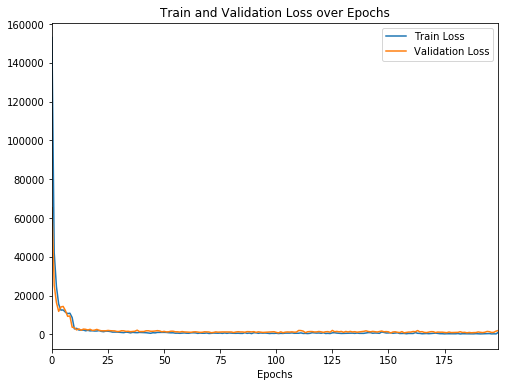

In [54]:
t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]
p = pd.DataFrame({'Train Loss': t, 'Validation Loss': v, 'Epochs': range(200)})

_ = p.plot(x='Epochs', y=['Train Loss', 'Validation Loss'], 
           title='Train and Validation Loss over Epochs')

In [55]:
m

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(124, 50)
  )
  (lins): ModuleList(
    (0): Linear(in_features=91, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=250, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (outp): Linear(in_features=250, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04, inplace=False)
  (drops): ModuleList(
    (0): Dropout(p=0.001, inplace=False)
    (1): Dropout(p=0.01, inplace=False)
    (2): Dropout(p=0.01, inplace=False)
  )
  (bn): BatchNorm1d(35, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [100]:
l = [x for x in feature_cols if x not in ['Industry', 'Sector']]
#m.eval()

X = financial_data[feature_cols]
Y = financial_data['Price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=123)
    
trainds = RegressionColumnarDataset(X_train, categorical, y_train)
valds = RegressionColumnarDataset(X_test, categorical, y_test)
 
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 0}
 
traindl = data.DataLoader(trainds, **params)
valdl = data.DataLoader(valds, **params)
one, two, three,  four,  five = valdl

m(one[0], one[1])

RuntimeError: Expected object of backend CUDA but got backend CPU for argument #3 'index'